# Q1


In [ ]:
#Seperated because of bugs from importing BJCK

import importlib
import Blackjack_simulator as bjck
importlib.reload(bjck)


<module 'Blackjack_simulator' from 'c:\\Users\\chuck\\Desktop\\ds543\\git\\BlackJack-RL-DQN\\Blackjack_simulator.py'>

In [246]:
import Blackjack_simulator as bjck
from Blackjack_simulator import deal
from Blackjack_simulator import draw
import gymnasium as gym
from typing import Optional, Tuple, Union
from gymnasium import logger, spaces

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Creating the environment class

In [247]:
class BlackJackEnv(gym.Env):
    def __init__(self):
        super(BlackJackEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(2)  # Hit or Stand
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, 1]), high=np.array([21, 4, 11]), dtype=np.float32)
        self.reset()

    def reset(self, *, seed: Optional[int] = 42, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.score, self.hand = deal()  
        self.aces = sum(1 for card in self.hand if card == 11)
        self.open_card = draw()  
        obs = np.array([self.score, self.aces, self.open_card], dtype=np.float32)
        return obs, {}  

    def rewardfnc(self, score):
        if score > 21:
            return -1
        else:
            dealers_total = bjck.dealer_from_hand(self.open_card)  
            if score > dealers_total:
                return 1
            elif score < dealers_total:
                return -1
            else:
                return 0

    def step(self, action):
        if action == 0:  # Stand
            reward = self.rewardfnc(self.score)
            return np.array([self.score, self.aces, self.open_card]), reward, True, False, {}  # Done is True on Stand

        card = draw() 
        self.score += card
        if card == 11:
            self.aces += 1

        while self.score > 21 and self.aces > 0:
            self.score -= 10
            self.aces -= 1

        terminated = self.score > 21
        reward = -1 if terminated else 0
        return np.array([self.score, self.aces, self.open_card]), reward, terminated, False, {}


In [248]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Random Agent Reward!

In [328]:

env = BlackJackEnv()
num_episodes = 10000
total_reward = 0

for _ in range(10000):
    state = env.reset()
    terminated = False
    episode_reward = 0
    
    while not terminated:
        action = env.action_space.sample()  # Choose random action (Hit or Stand)
        next_state, reward, terminated,_ , _ = env.step(action)
        episode_reward += reward
    
    total_reward += episode_reward

average_reward = total_reward / num_episodes

print(f"Average Reward over {num_episodes} episodes: {average_reward:.4f}")

Average Reward over 10000 episodes: -0.3632


# Q2

In [250]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)


    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [251]:

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 5000
TAU = 0.001
LR = 1e-4
seed = 20
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset(seed=seed)
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []




## Naive and Double DQN Optimizers

In [ ]:
def optimize_model_naive():
    if len(memory) < BATCH_SIZE:
        return 0
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    states = torch.cat(batch.state)
    actions = torch.cat(batch.action)
    rewards = torch.cat([torch.tensor([r], device=device) for r in batch.reward])
    next_states = torch.cat(batch.next_state)
    dones = torch.tensor(batch.done, dtype=torch.float32, device=device)

    # Compute Q(s_t, a)
    current_q = policy_net(states).gather(1, actions)

    # Compute V(s_{t+1}) using target network
    next_q = target_net(next_states).max(1)[0].detach()
    expected_q = rewards + (1 - dones) * GAMMA * next_q

    # Compute loss
    loss = F.mse_loss(current_q, expected_q.unsqueeze(1))
    
    # Optimize
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    
    return loss.item()
def optimize_model_double():
    if len(memory) < BATCH_SIZE:
        return 0
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    states = torch.cat(batch.state)
    actions = torch.cat(batch.action)
    rewards = torch.cat([torch.tensor([r], device=device) for r in batch.reward])
    next_states = torch.cat(batch.next_state)
    dones = torch.tensor(batch.done, dtype=torch.float32, device=device)

    # Compute Q(s_t, a)
    current_q = policy_net(states).gather(1, actions)

    # Double DQN specific logic
    with torch.no_grad():
        next_actions = policy_net(next_states).argmax(1, keepdim=True)
        next_q = target_net(next_states).gather(1, next_actions)
        expected_q = rewards + (1 - dones) * GAMMA * next_q

    loss = F.mse_loss(current_q, expected_q)
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    
    return loss.item()

## Put the training loop in a function for ease of use

In [ ]:
def train_dqn(use_double=False, num_episodes=1000):
    #Used single function for simplicity and readability
    episode_rewards = []
    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        total_reward = 0
        done = False

        while not done:
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            total_reward += reward
            done = terminated or truncated
            
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            memory.push(state, action, reward, next_state, done)
            state = next_state

            if use_double:
                loss = optimize_model_double()
            else:
                loss = optimize_model_naive()

            # Soft update target network
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

        episode_rewards.append(total_reward)
        
    return episode_rewards


In [254]:

def moving_average(data, window_size=500):
    """Compute the moving average of a given list of values."""
    # Ensure data is a flattened NumPy array
    data = np.array([t.item() if isinstance(t, torch.Tensor) else t for t in data], dtype=np.float32)
    if len(data) < window_size:
        raise ValueError(f"Window size ({window_size}) is larger than the data length ({len(data)})")
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

## Running naive and double DQN and making them plottable.

the params were tested a number of times. The policy nets, target nets, etc are retyped to make sure the enviromnents are working correctly, and reset. 

In [329]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 5000
TAU = 0.001
LR = 1e-4
seed = 20
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset(seed=seed)
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0
naive = train_dqn(False, 10000)
naive_ma = moving_average(naive)

In [256]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 5000
TAU = 0.001
LR = 1e-3
seed = 20
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset(seed=seed)
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

double = train_dqn(True, 10000)
double_ma = moving_average(double)

C:\Users\chuck\AppData\Local\Temp\ipykernel_8052\1951351567.py:58: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(current_q, expected_q)


## Multi DQN. Optimizer in a function, but the actual training loop is not, as it is right next to the plotting function, so it was unnecessary.

In [ ]:

def optimize_Multi_DQN():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    done_mask = torch.tensor(batch.done, device=device, dtype=torch.bool)
    non_final_mask = ~done_mask  # Invert to get non-terminal flags

    non_final_next_states_list = [s for s, done in zip(batch.next_state, batch.done) if not done]
    if non_final_next_states_list:
        non_final_next_states = torch.cat(non_final_next_states_list)
    else:
        non_final_next_states = None

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat([torch.tensor([r], device=device) for r in batch.reward])

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        if non_final_next_states is not None:
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = reward_batch + (GAMMA ** n_steps) * next_state_values

    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [258]:

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.001
LR = 1e-3
seed = 20
n_steps = 3
env = BlackJackEnv()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state, info = env.reset(seed=seed)
n_observations = len(state)
n_actions = env.action_space.n
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
n_step_buffer = deque()

In [259]:
# Training Loop with N-Step Learning
n_step_buffer = deque()

episode_rewards = []
num_episodes = 10000
for i_episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    n_step_buffer.clear()
    total_reward = 0    
    while True:
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        total_reward += reward

        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        done = terminated or truncated

        # Add to n-step buffer
        n_step_buffer.append( (state, action, reward, next_state, done) )

        if not done:
            while len(n_step_buffer) >= n_steps:
                transitions = list(n_step_buffer)[:n_steps]
                sum_reward = 0
                current_gamma = 1.0
                final_next_state = None
                done_flag = False

                for k in range(n_steps):
                    t = transitions[k]
                    sum_reward += current_gamma * t[2]
                    current_gamma *= GAMMA
                    if t[4]:
                        done_flag = True
                        final_next_state = t[3]
                        break
                    final_next_state = t[3]

                if not done_flag:
                    final_next_state = transitions[-1][3]

                memory.push(transitions[0][0], transitions[0][1], sum_reward.item(), final_next_state, done_flag)
                n_step_buffer.popleft()
        else:
            for i in range(len(n_step_buffer)):
                transitions = list(n_step_buffer)[i:]
                sum_reward = 0
                current_gamma = 1.0
                final_next_state = None
                done_flag = False

                for k in range(min(n_steps, len(transitions))):
                    t = transitions[k]
                    sum_reward += current_gamma * t[2]
                    current_gamma *= GAMMA
                    if t[4]:
                        done_flag = True
                        final_next_state = t[3]
                        break
                    final_next_state = t[3]

                memory.push(n_step_buffer[i][0], n_step_buffer[i][1], sum_reward.item(), final_next_state, done_flag)
            n_step_buffer.clear()

        state = next_state

        optimize_Multi_DQN()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break
    episode_rewards.append(total_reward)

print("Complete")

Complete


In [260]:


mult = episode_rewards
multi_ma = moving_average(mult)

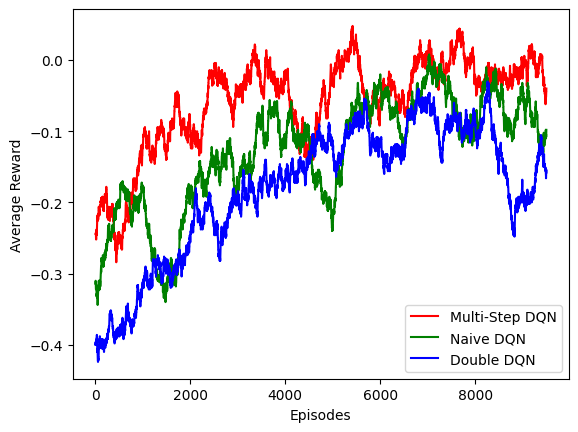

In [261]:
plt.plot(multi_ma,'r')
plt.plot(naive_ma,'g')
plt.plot(double_ma,'b')

plt.legend(['Multi-Step DQN', 'Naive DQN', 'Double DQN'])

plt.xlabel('Episodes')

plt.ylabel('Average Reward')

plt.show()


In [267]:
auc_naive = np.trapezoid(naive_ma)

auc_double = np.trapezoid(double_ma)

auc_multi = np.trapezoid(multi_ma)

print("AUC for Naive DQN:", auc_naive.mean())

print("AUC for Double DQN:", auc_double.mean())

print("AUC for Multi-Step DQN:", auc_multi.mean())

AUC for Naive DQN: -1224.346
AUC for Double DQN: -1724.5430000000003
AUC for Multi-Step DQN: -556.8620000000001


## I would say that Multi-step works the best. Double DQN seems to learn very slowly, and was not as effective in this environment. Naive DQN learns fast but is very volatitle. 

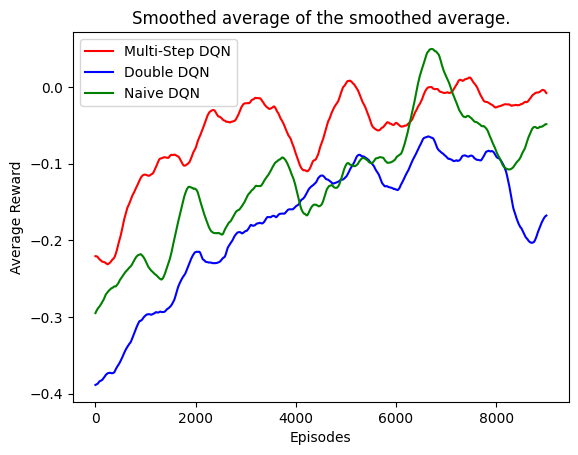

Makes it a little nicer to look at, and shows the actual trajectory of the agents


In [332]:
smootherNai = moving_average(naive_ma, window_size=500)

smootherDouble = moving_average(double_ma, window_size=500)

smootherMulti = moving_average(multi_ma, window_size=500)
plt.plot(smootherMulti,'r')
plt.plot(smootherDouble,'b')
plt.plot(smootherNai,'g')

plt.legend(['Multi-Step DQN', 'Double DQN','Naive DQN'])

plt.xlabel('Episodes')

plt.ylabel('Average Reward')
plt.title('Smoothed average of the smoothed average.')
plt.show()
print('Makes it a little nicer to look at, and shows the actual trajectory of the agents')

# Q3

In [287]:
from torch.distributions import Categorical

In [ ]:
class PolicyNetwork(nn.Module):
    '''Redone Policy Netwoek for PPO, TRPO, REINFORCE. '''
    def __init__(self, input_size=3, hidden_size=128, output_size=2):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  

In [ ]:
class REINFORCEAgent:
    def __init__(self, env, lr=1e-4, gamma=0.99):  # Lower learning rate
        self.env = env
        self.policy = PolicyNetwork()
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        
    def train(self, num_episodes=10000, batch_size=128):
        rewards = []
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            log_probs = []
            episode_rewards = []
            
            while True:
                state_tensor = torch.FloatTensor(state)
                action_logits = self.policy(state_tensor)
                dist = Categorical(logits=action_logits)  
                action = dist.sample()
                
                next_state, reward, terminated, truncated, _ = self.env.step(action.item())
                
                log_probs.append(dist.log_prob(action))
                episode_rewards.append(reward)
                
                if terminated or truncated:
                    break
                state = next_state
            
            # Calculate discounted returns
            returns = []
            G = 0
            for r in reversed(episode_rewards):
                G = r + self.gamma * G
                returns.insert(0, G)
            
            returns = torch.tensor(returns)
            if returns.std() > 0:  
                returns = (returns - returns.mean()) / returns.std()
            
            policy_loss = []
            for log_prob, G in zip(log_probs, returns):
                policy_loss.append(-log_prob * G)
            
            self.optimizer.zero_grad()
            policy_loss = torch.stack(policy_loss).sum()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)  # Gradient clipping,broken without
            self.optimizer.step()
            
            rewards.append(sum(episode_rewards))
        
        
        return rewards

In [ ]:

"""Helper functions for TRPO, to make the final TRPO implementation cleaner"""
def flat_grad(loss, model, create_graph=False):
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=create_graph)
    return torch.cat([grad.view(-1) for grad in grads])

def get_flat_params(model):
    return torch.cat([param.data.view(-1) for param in model.parameters()])

def set_flat_params(model, flat_params):
    index = 0
    for param in model.parameters():
        param_length = param.numel()
        new_param = flat_params[index:index+param_length].view(param.size())
        param.data.copy_(new_param)
        index += param_length

def conjugate_gradients(fvp, g, nsteps, residual_tol=1e-10):
    x = torch.zeros_like(g)
    r = g.clone()
    p = r.clone()
    rdotr = torch.dot(r, r)
    for i in range(nsteps):
        z = fvp(p)
        alpha = rdotr / (torch.dot(p, z) + 1e-8)
        x += alpha * p
        r -= alpha * z
        new_rdotr = torch.dot(r, r)
        if new_rdotr < residual_tol:
            break
        beta = new_rdotr / rdotr
        p = r + beta * p
        rdotr = new_rdotr
    return x

def compute_advantages(rewards, gamma):
    returns = []
    G = 0
    for r in rewards[::-1]:
        G = r + gamma * G
        returns.insert(0, G)
    returns = np.array(returns)
    advantages = (returns - returns.mean()) / (returns.std() + 1e-8)
    return advantages

def trpo_update(agent, trajectories, max_kl=1e-2, cg_iters=10, damping=1e-2):
    # Concatenate data from trajectories
    observations = torch.FloatTensor(np.concatenate([traj['observations'] for traj in trajectories], axis=0))
    actions = torch.LongTensor(np.concatenate([traj['actions'] for traj in trajectories], axis=0))
    advantages = torch.FloatTensor(np.concatenate([traj['advantages'] for traj in trajectories], axis=0))
    # Store old logits (from the policy when the data was collected)
    old_logits = torch.FloatTensor(np.concatenate([traj['old_logits'] for traj in trajectories], axis=0))
    
    # Old distribution
    old_dist = Categorical(logits=old_logits)
    old_log_probs = old_dist.log_prob(actions).detach()
    
    # Surrogate loss
    new_logits = agent.policy(observations)
    new_dist = Categorical(logits=new_logits)
    new_log_probs = new_dist.log_prob(actions)
    ratio = torch.exp(new_log_probs - old_log_probs)
    surrogate_loss = -torch.mean(ratio * advantages)  # minimizing negative surrogate objective

    # Compute gradient of the surrogate loss
    grad_surrogate = flat_grad(surrogate_loss, agent.policy)
    
    # Fisher-vector product function
    def fisher_vector_product(v):
        new_logits = agent.policy(observations)
        new_dist = Categorical(logits=new_logits)
        # Compute the mean KL divergence between old and new policies
        kl = torch.distributions.kl.kl_divergence(old_dist, new_dist).mean()
        kl_grad = flat_grad(kl, agent.policy, create_graph=True)
        kl_grad_v = (kl_grad * v).sum()
        fisher_v = flat_grad(kl_grad_v, agent.policy).detach()
        return fisher_v + damping * v

    step_direction = conjugate_gradients(fisher_vector_product, grad_surrogate, cg_iters)
    
    shs = 0.5 * (step_direction * fisher_vector_product(step_direction)).sum(0, keepdim=True)
    lagrange_multiplier = torch.sqrt(shs / max_kl)
    full_step = step_direction / (lagrange_multiplier + 1e-8)
    
    old_params = get_flat_params(agent.policy)
    
    def set_and_eval(step):
        new_params = old_params - step  
        set_flat_params(agent.policy, new_params)
        new_logits = agent.policy(observations)
        new_dist = Categorical(logits=new_logits)
        new_log_probs = new_dist.log_prob(actions)
        ratio = torch.exp(new_log_probs - old_log_probs)
        surrogate_loss_new = -torch.mean(ratio * advantages)
        kl = torch.distributions.kl.kl_divergence(old_dist, new_dist).mean()
        return surrogate_loss_new, kl

    #expected_improve = (grad_surrogate * full_step).sum(0, keepdim=True)
    fraction = 1.0
    for _ in range(10):
        step = fraction * full_step
        surrogate_loss_new, kl = set_and_eval(step)
        if kl < max_kl and surrogate_loss_new < surrogate_loss:
            break
        fraction *= 0.5
    else:
        set_flat_params(agent.policy, old_params)
    
    return surrogate_loss.item(), kl.item()

class TRPOAgent:
    def __init__(self, env, gamma=0.99, max_kl=1e-2, cg_iters=10, damping=1e-2):
        self.env = env
        self.policy = PolicyNetwork() 
        self.gamma = gamma
        self.max_kl = max_kl
        self.cg_iters = cg_iters
        self.damping = damping

    def collect_trajectory(self):
        states, actions, rewards, old_logits = [], [], [], []
        state, _ = self.env.reset()
        while True:
            state_tensor = torch.FloatTensor(state)
            logits = self.policy(state_tensor)
            dist = Categorical(logits=logits)
            action = dist.sample()
            states.append(state)
            actions.append(action.item())
            # Save the logits as the “old” policy
            old_logits.append(logits.detach().numpy())
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            rewards.append(reward)
            if terminated or truncated:
                break
            state = next_state
        return {
            'observations': np.array(states),
            'actions': np.array(actions),
            'rewards': np.array(rewards),
            'old_logits': np.array(old_logits)
        }
    
    def train(self, num_iterations=100, batch_size=128):
        rewards_history = []
        for iteration in range(num_iterations):
            trajectories = []
            batch_rewards = []
            while len(trajectories) < batch_size:
                traj = self.collect_trajectory()
                traj['advantages'] = compute_advantages(traj['rewards'], self.gamma)
                trajectories.append(traj)
                batch_rewards.append(sum(traj['rewards']))
            
            loss, kl = trpo_update(self, trajectories, self.max_kl, self.cg_iters, self.damping)
            avg_reward = np.mean(batch_rewards)
            rewards_history.append(avg_reward)
        return rewards_history





In [291]:
class PPOAgent:
    def __init__(self, env, clip_param=0.2, lr=3e-4, gamma=0.99, entropy_coef=0.01):
        self.env = env
        self.policy = PolicyNetwork()
        self.old_policy = PolicyNetwork()
        self.old_policy.load_state_dict(self.policy.state_dict())
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.clip_param = clip_param
        self.gamma = gamma
        self.entropy_coef = entropy_coef

    def train(self, num_batches=10000, batch_size=256, epochs=4):
        rewards = []
        for batch in range(num_batches):
            states = []
            actions = []
            old_log_probs = []
            rewards_list = []
            dones = []
            
            # Collect data using old policy
            with torch.no_grad():
                for _ in range(batch_size):
                    state, _ = self.env.reset()
                    episode_rewards = []
                    
                    while True:
                        state_tensor = torch.FloatTensor(state)
                        action_logits = self.old_policy(state_tensor)
                        dist = Categorical(logits=action_logits)
                        action = dist.sample()
                        
                        next_state, reward, terminated, truncated, _ = self.env.step(action.item())
                        
                        states.append(state)
                        actions.append(action.item())
                        old_log_probs.append(dist.log_prob(action))
                        rewards_list.append(reward)
                        dones.append(terminated or truncated)
                        
                        if terminated or truncated:
                            break
                        state = next_state

            # Convert to tensors
            states = torch.FloatTensor(np.array(states))
            actions = torch.LongTensor(actions)
            old_log_probs = torch.stack(old_log_probs)
            
            # Calculate advantages
            returns = []
            G = 0
            for r in reversed(rewards_list):
                G = r + self.gamma * G
                returns.insert(0, G)
            returns = torch.FloatTensor(returns)
            advantages = returns - returns.mean()
            if returns.std() > 0:
                advantages = (advantages) / (returns.std() + 1e-8)
            
            # Update policy
            for _ in range(epochs):
                action_logits = self.policy(states)
                dist = Categorical(logits=action_logits)
                new_log_probs = dist.log_prob(actions)
                entropy = dist.entropy().mean()
                
                ratios = torch.exp(new_log_probs - old_log_probs)
                surr1 = ratios * advantages
                surr2 = torch.clamp(ratios, 1-self.clip_param, 1+self.clip_param) * advantages
                
                policy_loss = -torch.min(surr1, surr2).mean()
                entropy_loss = -self.entropy_coef * entropy
                total_loss = policy_loss + entropy_loss
                
                self.optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
                self.optimizer.step()
            
            self.old_policy.load_state_dict(self.policy.state_dict())
            rewards.append(np.mean(rewards_list))
            
            
        
        return rewards

C:\Users\chuck\AppData\Local\Temp\ipykernel_8052\1498826208.py:38: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1831.)
  if returns.std() > 0:  # Prevent division by zero


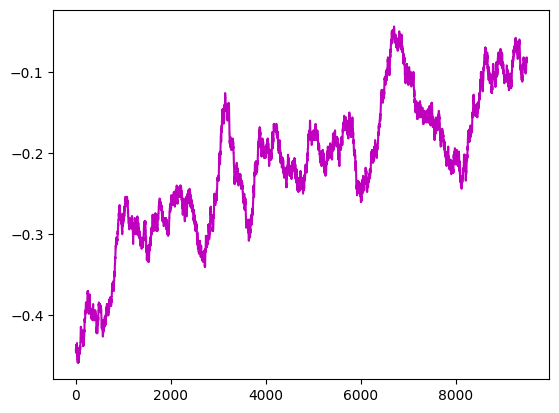

REINFORCE AUC: -2187


In [352]:
#testing reinforce
reinforceer = REINFORCEAgent(env, lr=1e-5, gamma=0.9)

reinforce_rewardser = reinforceer.train(num_episodes=10000, batch_size=128)
plt.plot(moving_average(reinforce_rewardser,500),'m')
plt.show()
print(f"REINFORCE AUC: {sum(reinforce_rewardser)}")

C:\Users\chuck\AppData\Local\Temp\ipykernel_8052\1498826208.py:38: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1831.)
  if returns.std() > 0:  # Prevent division by zero


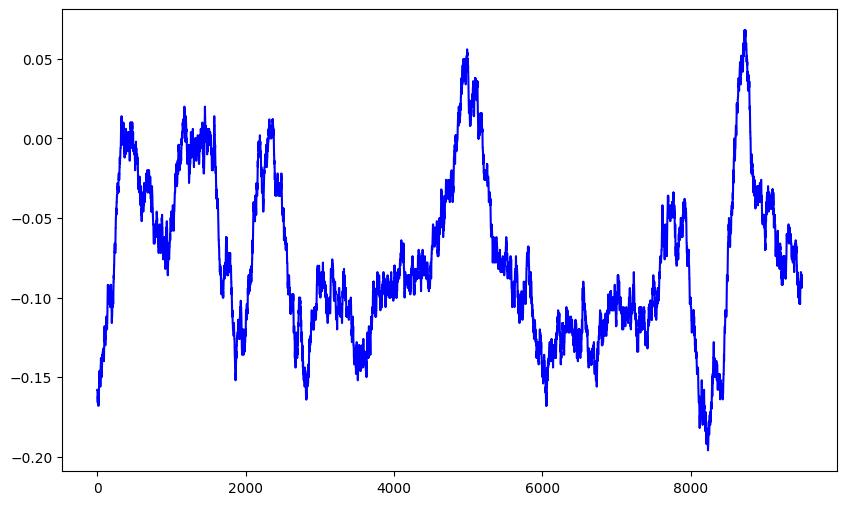

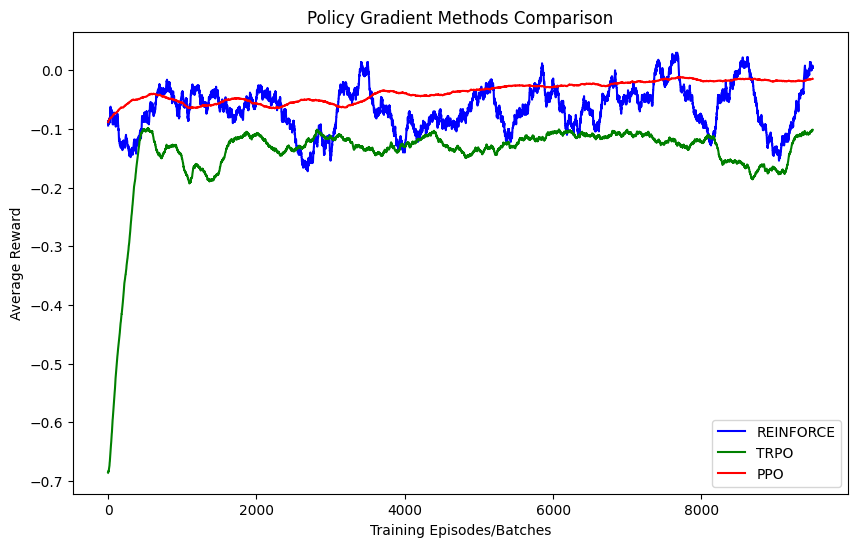

REINFORCE AUC: -638
TRPO AUC: -1556.75
PPO AUC: -376.40640733620637


In [ ]:
env = BlackJackEnv()
    
# Trin REINFORCE
reinforce = REINFORCEAgent(env, lr=1e-3, gamma=0.99)
reinforce_rewards = reinforce.train(num_episodes=10000, batch_size=128)

# Train TRPO
trpo = TRPOAgent(env)
trpo_rewards = trpo.train(num_iterations=10000,batch_size=16)

# Train PPO
ppo = PPOAgent(env, clip_param=0.2, lr=3e-4, gamma=0.99)
ppo_rewards = ppo.train(num_batches=10000, batch_size=256)




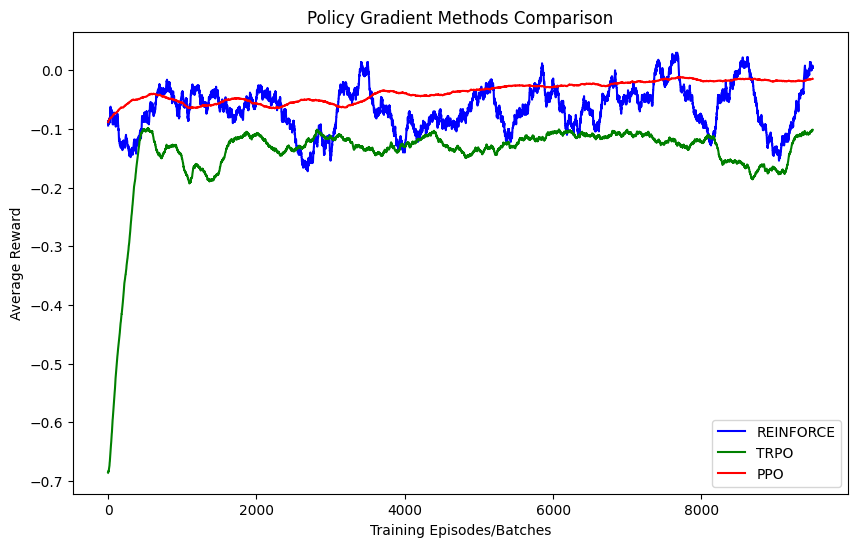

REINFORCE AUC: -638
TRPO AUC: -1556.75
PPO AUC: -376.40640733620637


In [333]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(moving_average(reinforce_rewards,500), 'b', label='REINFORCE')
plt.plot(moving_average(trpo_rewards,500), 'g', label='TRPO')
plt.plot(moving_average(ppo_rewards, 500), 'r', label='PPO')
plt.xlabel('Training Episodes/Batches')
plt.ylabel('Average Reward')
plt.title('Policy Gradient Methods Comparison')
plt.legend()
plt.show()
    
# Calculate AUC
print(f"REINFORCE AUC: {sum(reinforce_rewards)}")
print(f"TRPO AUC: {sum(trpo_rewards)}")
print(f"PPO AUC: {sum(ppo_rewards)}")

## In general,
PPO is very good. it learns very fast and is very consistent (on a per episode basis.) TRPO is slower, and doesnt learn as well, but is more stable than REINFORCE. 
REINFORCE is not stable, but learns fast, and at least for my implementation ran extremely fast. But considering the PPO AUCs score is so much closer to 1, i would say PPO
is the best of the three models, even if it takes a long time to run. 

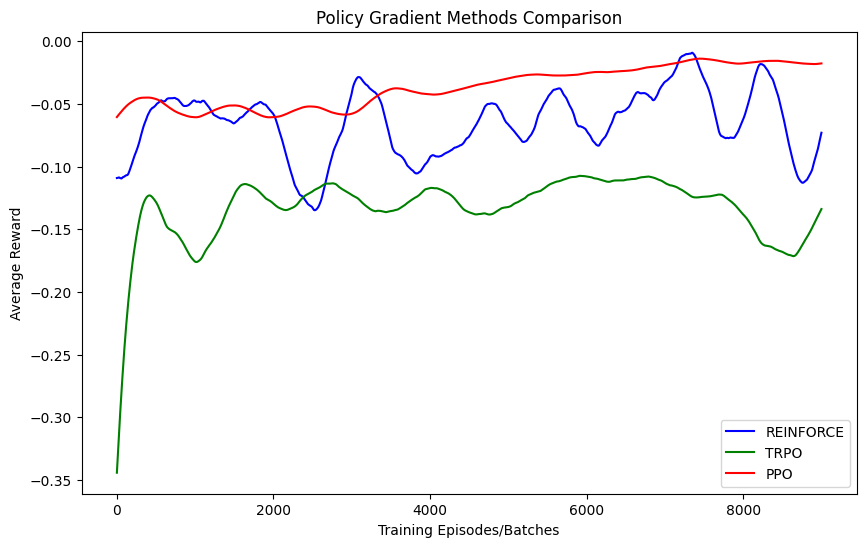

Extra smooth! Again makes for better clarity. Look how smooth PPO is!


In [335]:
plt.figure(figsize=(10, 6))
plt.plot(moving_average(moving_average(reinforce_rewards,500),500), 'b', label='REINFORCE')
plt.plot(moving_average(moving_average(trpo_rewards,500),500), 'g', label='TRPO')
plt.plot(moving_average(moving_average(ppo_rewards, 500),500), 'r', label='PPO')
plt.xlabel('Training Episodes/Batches')
plt.ylabel('Average Reward')
plt.title('Policy Gradient Methods Comparison')
plt.legend()
plt.show()
print('Extra smooth! Again makes for better clarity. Look how smooth PPO is!')

# Q4

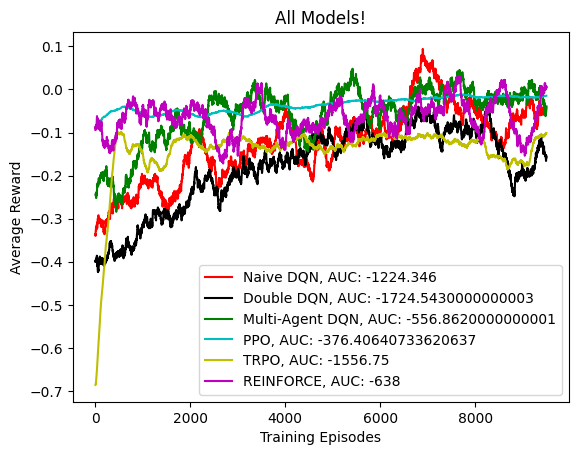

In [ ]:
plt.plot(naive_ma,'r',label = f'Naive DQN, AUC: {auc_naive}')
plt.plot(double_ma,'k',label = f'Double DQN, AUC: {auc_double}')
plt.plot(multi_ma,'g',label = f'Multi-Agent DQN, AUC: {auc_multi}')
plt.plot(moving_average(ppo_rewards,500),'c',label = f'PPO, AUC: {sum(ppo_rewards)}')
plt.plot(moving_average(trpo_rewards,500),'y',label = f'TRPO, AUC: {sum(trpo_rewards)}')
plt.plot(moving_average(reinforce_rewards,500),'m',label = f'REINFORCE, AUC: {sum(reinforce_rewards)}')
plt.xlabel('Training Episodes')
plt.ylabel('Average Reward')
plt.title('All Models! Single Smoothed')
plt.legend()
plt.show()


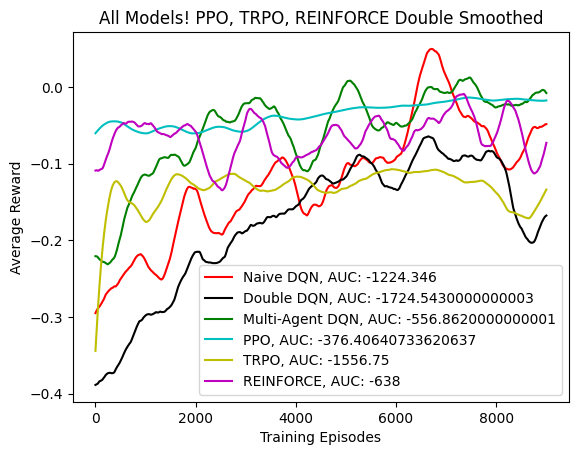

In [347]:
plt.plot(moving_average(naive_ma,500),'r',label = f'Naive DQN, AUC: {auc_naive}')
plt.plot(moving_average(double_ma, 500), 
         'k', label=f'Double DQN, AUC: {auc_double}')
plt.plot(moving_average(multi_ma, 500), 
         'g', label=f'Multi-Agent DQN, AUC: {auc_multi}')
plt.plot(moving_average(moving_average(ppo_rewards, 500), 500), 
         'c', label=f'PPO, AUC: {sum(ppo_rewards)}')
plt.plot(moving_average(moving_average(trpo_rewards, 500), 500), 
         'y', label=f'TRPO, AUC: {sum(trpo_rewards)}')
plt.plot(moving_average(moving_average(reinforce_rewards, 500), 500), 
         'm', label=f'REINFORCE, AUC: {sum(reinforce_rewards)}')
plt.xlabel('Training Episodes')
plt.ylabel('Average Reward')
plt.title('All Models! PPO, TRPO, REINFORCE Double Smoothed')
plt.legend()
plt.show()


## Analysis

PPO and TRPO are very consistent in their learning. They are also both robust, being relativley unsensitive to hyperparameters. They both take a long time to run however. 
Reinforce learns fast, but is not as consistent as PPO and TRPO. It also is relativley sensitive to hyperparameters, although not as much as the DQNs. Learning rate can make 
the reinforce agent learn slower or faster by a large margin, although over a long time it does still learn. REINFORCE's main advantage in my implementation is that it
runs FAST

Naive DQN is the least consistent but is fast, and easy to implement. It works well enough for this environment, but is far from the best. Its also relativley sensitive to hyperparameters, 
namely Epsilon decay.
